# Boston Marathon timing

This is a visualization of the Boston Marathon time, focusing of the pace and split time during the race.

Boston was used from https://github.com/llimllib/bostonmarathon

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans,SpectralClustering,DBSCAN
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

In [2]:
data = pd.read_csv("results.csv")

In [3]:
data.columns

Index(['25k', 'age', 'name', 'division', '10k', 'gender', 'half', 'official',
       'bib', 'ctz', 'country', 'overall', 'pace', 'state', '30k', '5k',
       'genderdiv', '20k', '35k', 'city', '40k'],
      dtype='object')

# Transform the data to a numeric format

In [3]:
data = data.replace("-",np.nan)
for col in ['25k', 'age', '10k', 'half', 'official', 'overall'
          , 'pace','30k', '5k', 'genderdiv', '20k', '35k', '40k']:
    data[col] = pd.to_numeric(data[col])

In [4]:
data.sample(10)

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
14966,140.93,49,"Pinto, Joan R",979,53.95,F,116.77,244.93,18401,NaN,...,16770,9.35,CA,171.43,26.53,6513,110.52,202.43,Orinda,232.05
7740,111.33,57,"Harris, Harry R.",79,44.23,M,93.78,193.87,9377,NaN,...,4494,7.40,IL,134.65,22.22,4023,88.95,158.83,Chicago,183.23
5388,108.72,55,"Waywell, Elizabeth A",5,43.35,F,91.55,190.28,6521,CAN,...,3788,7.27,NY,132.92,21.98,338,86.77,156.85,Dix Hills,180.15
3197,116.68,31,"Hsia, Brian W.",3216,44.10,M,96.72,216.58,3910,NaN,...,10263,8.27,NY,146.53,22.05,7436,91.42,177.00,New York,205.72
9820,120.40,30,"Giesler, Karen R",846,49.27,F,101.95,202.42,11919,NaN,...,6408,7.73,CO,144.58,25.15,1037,96.80,168.37,Fort Collins,191.92
2813,99.42,26,"Bourdel, Anthony",811,39.73,M,83.85,173.37,3462,NaN,...,1095,6.62,NaN,119.92,19.88,1032,79.50,141.03,Nanterre,163.68
964,98.10,24,"Welsh, Tyler E",648,39.33,M,82.60,170.40,1202,NaN,...,850,6.50,PA,118.42,19.63,805,78.37,139.40,Wellsboro,160.82
13074,130.97,37,"Pauler, Shae",3294,52.48,F,110.23,234.57,15970,NaN,...,14915,8.95,TX,159.72,26.55,5422,104.58,191.23,Brenham,221.53
15953,139.77,53,"Mah, Deveda",483,53.42,F,116.13,244.75,20161,NaN,...,16750,9.35,AB,170.70,26.10,6499,110.00,202.25,Edmonton,231.43
14364,129.50,60,"Rikely, Daniel",332,50.30,M,108.43,234.63,17597,NaN,...,14935,8.95,ON,158.37,25.08,9501,102.78,189.35,Toronto,220.78


# Let's look at the running time during the marathon...

In [5]:
running_time = data[["5k",'10k',"20k",'half','25k','30k','35k','40k','official']].stack().reset_index().rename(columns={0:"data"})



# Running time during the Marathon

We can see the initially compact group of time at 5k and 10k slowly strech as the marathon goes the end.

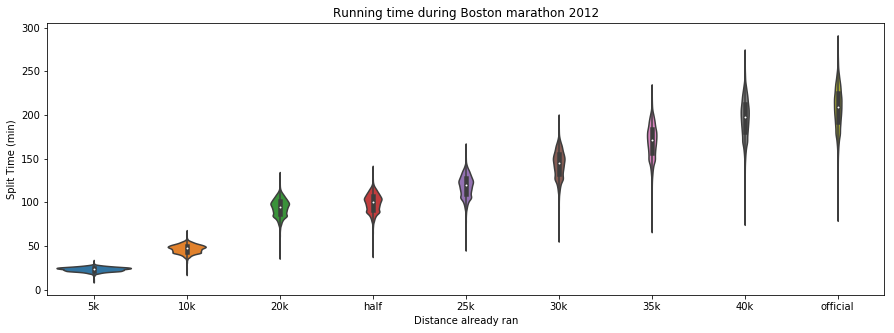

In [7]:
plt.figure(figsize=(15,5));
sns.violinplot(data=running_time, x="level_1",y="data")
plt.title("Running time during Boston marathon 2012")
plt.xlabel("Distance already ran");
plt.ylabel("Split Time (min)");

# Focusing on regular 5k intervals.

We will not look at the time at the half and the end of the marathon, but look at the time that are taken every 5km (with the exception of 15k).

In [16]:
running_time_5k = data[["5k",'10k',"20k",'25k','30k','35k','40k']].stack().reset_index().rename(columns={0:"data"})



In [17]:
running_time_5k["distance"] = running_time_5k["level_1"].map({"5k":5000,"10k":10000,"20k":20000,"half":42195//2,
                                             "25k":25000,"30k":30000,"35k":35000,"40k":40000,"official":42195,})

# Calculation average time:

Using shift function, we have on each line the prevision time. For the initial 5k time, we make sure the initial line "prev_" feature are 0.

`level_0` is the runner reference runner. We also make sure that the data is properly "aligned" by looking the case when `level_0` is not equal to `prev_level_0`

In [18]:
running_time_5k[["prev_data","prev_distance","prev_level_0"]] = running_time_5k[["data","distance","level_0"]].shift()

In [19]:
running_time_5k.sample(5)

,level_0,level_1,data,distance,prev_data,prev_distance,prev_level_0
102143,14617,30k,160.15,30000,130.43,25000.0,14617.0
48556,6948,10k,45.55,10000,22.97,5000.0,6948.0
42780,6121,25k,107.53,25000,85.95,20000.0,6121.0
67896,9716,30k,146.57,30000,122.05,25000.0,9716.0
25669,3673,5k,21.23,5000,197.82,40000.0,3672.0


In [20]:
running_time_5k.loc[running_time_5k.level_0 != running_time_5k.prev_level_0, "prev_data"] = 0 
running_time_5k.loc[running_time_5k.level_0 != running_time_5k.prev_level_0, "prev_distance"] = 0 


In [21]:
running_time_5k[running_time_5k.level_0 != running_time_5k.prev_level_0].sample(10)

,level_0,level_1,data,distance,prev_data,prev_distance,prev_level_0
60294,8629,5k,24.05,5000,0.0,0.0,8628.0
70187,10044,5k,25.27,5000,0.0,0.0,10043.0
5074,726,5k,24.10,5000,0.0,0.0,725.0
26180,3746,5k,21.60,5000,0.0,0.0,3745.0
95841,13716,5k,25.77,5000,0.0,0.0,13715.0
20614,2950,5k,20.40,5000,0.0,0.0,2949.0
49218,7043,5k,23.53,5000,0.0,0.0,7042.0
110954,15877,5k,26.67,5000,0.0,0.0,15876.0
89317,12782,5k,24.23,5000,0.0,0.0,12781.0
109232,15631,5k,26.63,5000,0.0,0.0,15630.0


In [22]:
running_time_5k["current_time"] = running_time_5k.data - running_time_5k.prev_data
running_time_5k["latest_avg_speed"] = 60/1000*(running_time_5k.distance - running_time_5k.prev_distance)/running_time_5k.current_time

In [23]:
running_time_5k.loc[running_time_5k.level_1=="20k","current_time"] = running_time_5k.current_time/2

# Time to run the last 5k before the milestone

Except for the "20k" milestone (we do not have the "15k" milestone), we can calculate the time the runner took to run the previous 5 km.

We can notice the regularity of most of the time, the milestone that see the highest time being the 30k miletone and 40k at the end of the race.



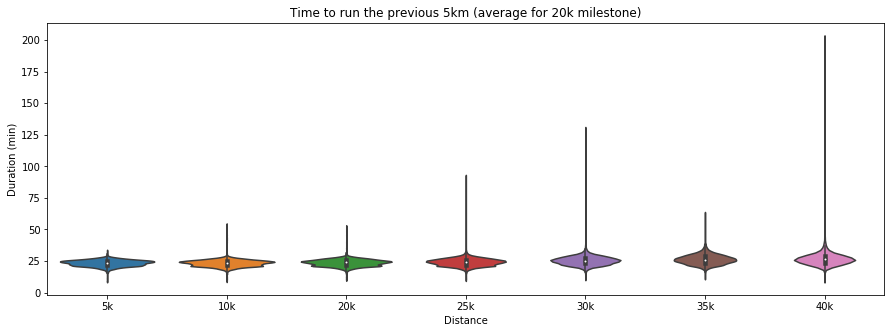

In [24]:
plt.figure(figsize=(15,5));
sns.violinplot(data=running_time_5k, x="level_1",y="current_time");
plt.title("Time to run the previous 5km (average for 20k milestone)");
plt.xlabel("Distance");
plt.ylabel("Duration (min)");


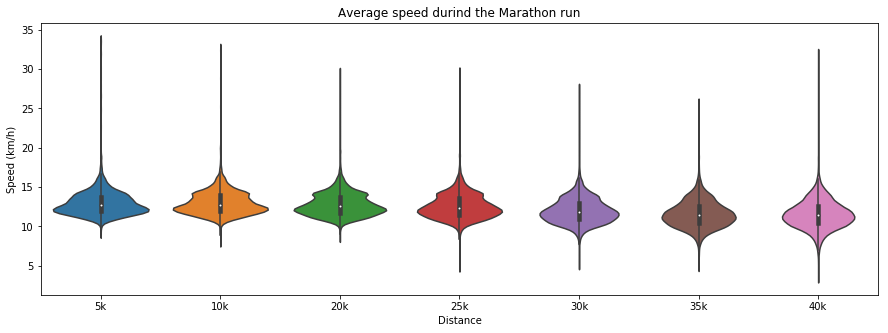

In [25]:
plt.figure(figsize=(15,5));
sns.violinplot(data=running_time_5k, x="level_1",y="latest_avg_speed")
plt.title("Average speed durind the Marathon run");
plt.xlabel("Distance");
plt.ylabel("Speed (km/h)");

# Above 30 km/h average !

Let's check the runner that were able to run above 30 km/h.

In [26]:
running_time_5k[running_time_5k.latest_avg_speed>30]

,level_0,level_1,data,distance,prev_data,prev_distance,prev_level_0,current_time,latest_avg_speed
0,0,5k,8.90,5000,0.00,0.0,NaN,8.90,33.707865
1,0,10k,18.18,10000,8.90,5000.0,0.0,9.28,32.327586
21,3,5k,8.98,5000,0.00,0.0,2.0,8.98,33.407572
22,3,10k,18.73,10000,8.98,5000.0,3.0,9.75,30.769231
28,4,5k,8.92,5000,0.00,0.0,3.0,8.92,33.632287
29,4,10k,18.18,10000,8.92,5000.0,4.0,9.26,32.397408
42,6,5k,8.98,5000,0.00,0.0,5.0,8.98,33.407572
43,6,10k,18.73,10000,8.98,5000.0,6.0,9.75,30.769231
56,8,5k,9.38,5000,0.00,0.0,7.0,9.38,31.982942
77,11,5k,8.92,5000,0.00,0.0,10.0,8.92,33.632287


In [27]:
data["second_half_time"] = data.official- data.half


# Half and Second half time

Let's look at the correlation between the time to complete the first half and the second half (that is official time minus the half time).

They are both stronly correlation, the second half is usually greater than the first half time, especially for bigger half-timme.

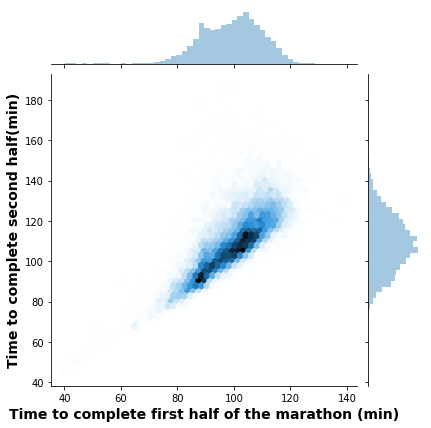

In [29]:
h = sns.jointplot(data.half,data.second_half_time, kind="hex")
h.set_axis_labels('x', 'y', fontsize=14)

# or set labels via the axes objects
h.ax_joint.set_xlabel('Time to complete first half of the marathon (min)', fontweight='bold');
h.ax_joint.set_ylabel('Time to complete second half(min)', fontweight='bold');


In [34]:
import pandas_profiling
pandas_profiling.ProfileReport(data[["half","second_half_time"]])

Number of variables,2
Number of observations,16164
Total Missing (%),0.1%
Total size in memory,252.6 KiB
Average record size in memory,16.0 B
Numeric,2
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [30]:
dat_for_cluster = data[["half","second_half_time"]].dropna()

In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(dat_for_cluster, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(dat_for_cluster)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))



Number of estimated clusters: 2


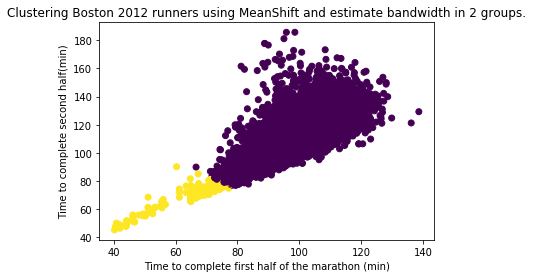

In [32]:
plt.scatter(dat_for_cluster.half, dat_for_cluster.second_half_time, c=labels)
plt.xlabel('Time to complete first half of the marathon (min)');
plt.ylabel('Time to complete second half(min)');
plt.title("Clustering Boston 2012 runners using MeanShift and estimate bandwidth in 2 groups.");

In [33]:
from sklearn.cluster import KMeans
# We know we're looking for 7 clusters.
n_clusters=7

# Declare and fit the model.
sc = KMeans(n_clusters=n_clusters)
sc.fit(dat_for_cluster)

#Predicted clusters.
predict=sc.fit_predict(dat_for_cluster)

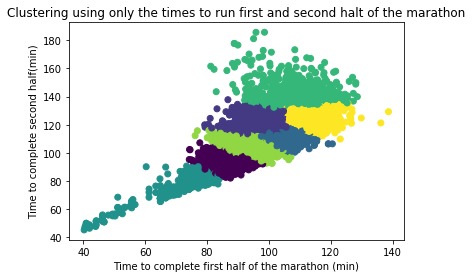

In [34]:
plt.scatter(dat_for_cluster.half, dat_for_cluster.second_half_time, c=predict)
plt.title("Clustering using only the times to run first and second halt of the marathon");
plt.xlabel('Time to complete first half of the marathon (min)');
plt.ylabel('Time to complete second half(min)');

# Clustering using speed


In [35]:
data["10k_last_5k"] = data["10k"] - data["5k"]
data["20k_last_10k"] = data["20k"] - data["10k"]
data["25k_last_5k"] = data["25k"] - data["20k"]
data["30k_last_5k"] = data["30k"] - data["25k"]
data["35k_last_5k"] = data["35k"] - data["30k"]
data["40k_last_5k"] = data["40k"] - data["35k"]

In [36]:
data["5k_speed"] = 5/(data["5k"]/60)
data["10k_speed"] = 5/(data["10k_last_5k"]/60)
data["20k_speed"] = 10/(data["20k_last_10k"]/60)
data["25k_speed"] = 5/(data["25k_last_5k"]/60)
data["30k_speed"] = 5/(data["30k_last_5k"]/60)
data["35k_speed"] = 5/(data["35k_last_5k"]/60)
data["40k_speed"] = 5/(data["40k_last_5k"]/60)

In [37]:
speeds = ["5k_speed","10k_speed","20k_speed","25k_speed","30k_speed","35k_speed","40k_speed"]

In [38]:
data_for_cluster = data[speeds+["half","second_half_time"]].dropna()
data_only_speed = data_for_cluster[speeds]

In [40]:
from sklearn.cluster import KMeans
# We know we're looking for 7 clusters.
n_clusters=7

# Declare and fit the model.
sc = KMeans(n_clusters=n_clusters)
sc.fit(data_only_speed)

#Predicted clusters.
predict=sc.fit_predict(data_only_speed)

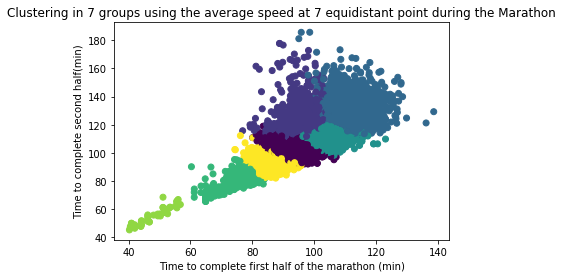

In [41]:
plt.scatter(data_for_cluster.half, data_for_cluster.second_half_time, c=predict)
plt.title("Clustering in 7 groups using the average speed at 7 equidistant point during the Marathon");
plt.xlabel('Time to complete first half of the marathon (min)');
plt.ylabel('Time to complete second half(min)');

Using the different dimension allows us to use get different clustering of the runners of the Boston Marathon.

In [42]:
mean_shift_3 = MeanShift(bandwidth=3).fit(data_only_speed)

In [43]:
mean_shift_2 = MeanShift(bandwidth=2).fit(data_only_speed)
mean_shift_4 = MeanShift(bandwidth=4).fit(data_only_speed)

In [44]:
data_for_cluster["Mean Shift bandwith 2"] = mean_shift_2.labels_
data_for_cluster["Mean Shift bandwith 3"] = mean_shift_3.labels_
data_for_cluster["Mean Shift bandwith 4"] = mean_shift_4.labels_



In [53]:
data_for_cluster["Mean Shift bandwith 4"].value_counts()

0     15012
9       909
7        32
4        29
8        20
1        14
2        12
3        11
10        9
5         4
6         1
11        1
Name: Mean Shift bandwith 4, dtype: int64

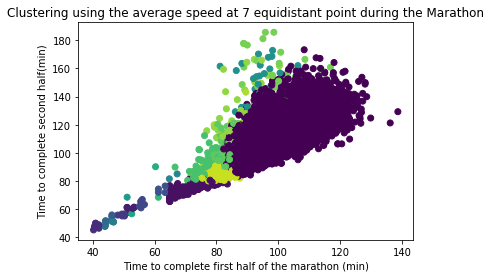

In [45]:
plt.scatter(data_for_cluster.half, data_for_cluster.second_half_time, c=mean_shift_3.labels_)
plt.title("Clustering using the average speed at 7 equidistant point during the Marathon");
plt.xlabel('Time to complete first half of the marathon (min)');
plt.ylabel('Time to complete second half(min)');

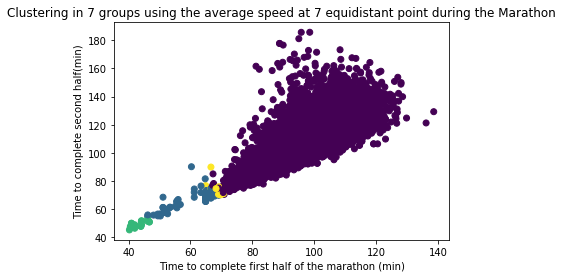

In [46]:
clustering_7 = MeanShift(bandwidth=7).fit(data_only_speed)
plt.scatter(data_for_cluster.half, data_for_cluster.second_half_time, c=clustering_7.labels_)
plt.title("Clustering in 7 groups using the average speed at 7 equidistant point during the Marathon");
plt.xlabel('Time to complete first half of the marathon (min)');
plt.ylabel('Time to complete second half(min)');

In [47]:
data_for_cluster["Mean Shift 7 groups"] = clustering_7.labels_
data_for_cluster["Mean Shift 7 groups"].unique()

array([2, 1, 3, 0])

In [48]:
data_for_cluster.head()

,5k_speed,10k_speed,20k_speed,25k_speed,30k_speed,35k_speed,40k_speed,half,second_half_time,Mean Shift bandwith 2,Mean Shift bandwith 3,Mean Shift bandwith 4,Mean Shift 7 groups
0,33.707865,32.327586,29.097963,27.100271,24.590164,23.696682,27.726433,40.93,49.97,13,3,2,2
1,18.867925,20.000000,19.595036,19.047619,19.108280,18.975332,18.761726,64.90,67.60,1,1,7,1
2,18.832392,20.040080,19.588639,19.108280,19.367334,18.796992,19.867550,64.92,65.45,1,1,7,1
3,33.407572,30.769231,28.368794,28.248588,27.649770,25.751073,28.763183,42.00,46.43,3,3,2,2
4,33.632287,32.397408,29.455081,29.411765,26.857654,25.510204,29.411765,40.57,46.65,2,3,2,2


In [ ]:
spectral_7 = SpectralClustering(n_clusters=7,assign_labels="discretize",random_state=0).fit(data_only_speed)



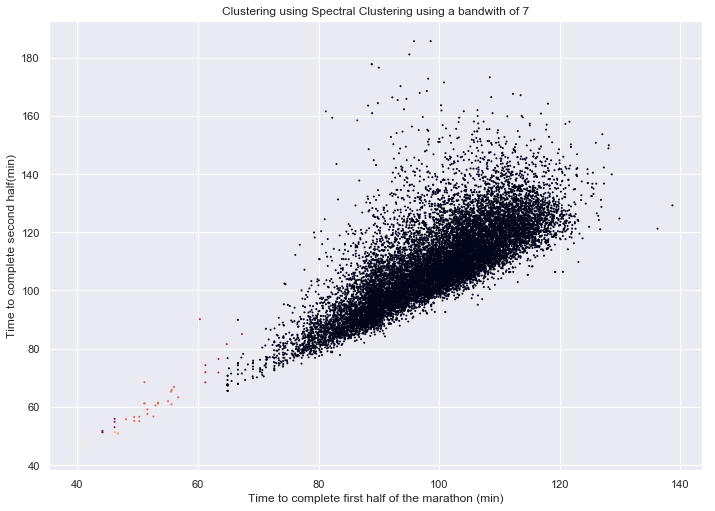

In [123]:
plt.scatter(data_for_cluster.half, data_for_cluster.second_half_time, c=spectral_7.labels_,s=1)
plt.title("Clustering using Spectral Clustering using a bandwith of 7");
plt.xlabel('Time to complete first half of the marathon (min)');
plt.ylabel('Time to complete second half(min)');

In [87]:
data_for_cluster["Spectral Clustering"] = spectral_7.labels_



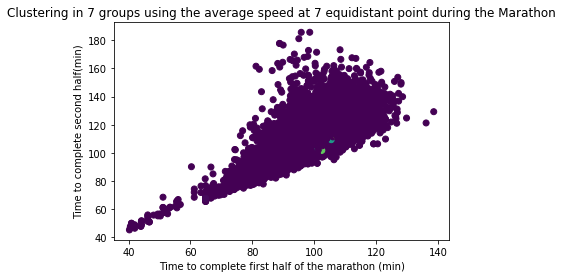

In [43]:
dbscan = DBSCAN(eps=.18)
dbscan_boston = dbscan.fit(data_only_speed)
plt.scatter(data_for_cluster.half, data_for_cluster.second_half_time, c=dbscan.labels_)
plt.title("Clustering in 7 groups using the average speed at 7 equidistant point during the Marathon");
plt.xlabel('Time to complete first half of the marathon (min)');
plt.ylabel('Time to complete second half(min)');

In [45]:
dbscan.labels_

array([-1,  0, -1, ..., -1, -1, -1])

In [88]:
show_speeds = data_for_cluster[speeds].stack().to_frame().reset_index()\
                        .rename(columns={"level_0":"runner","level_1":"speeds"})\
                        

In [92]:
cluster_labels = ["Mean Shift 7 groups","Spectral Clustering"]

show_speeds_with_groups = pd.merge(show_speeds,data_for_cluster[cluster_labels],right_index=True, left_on='runner')


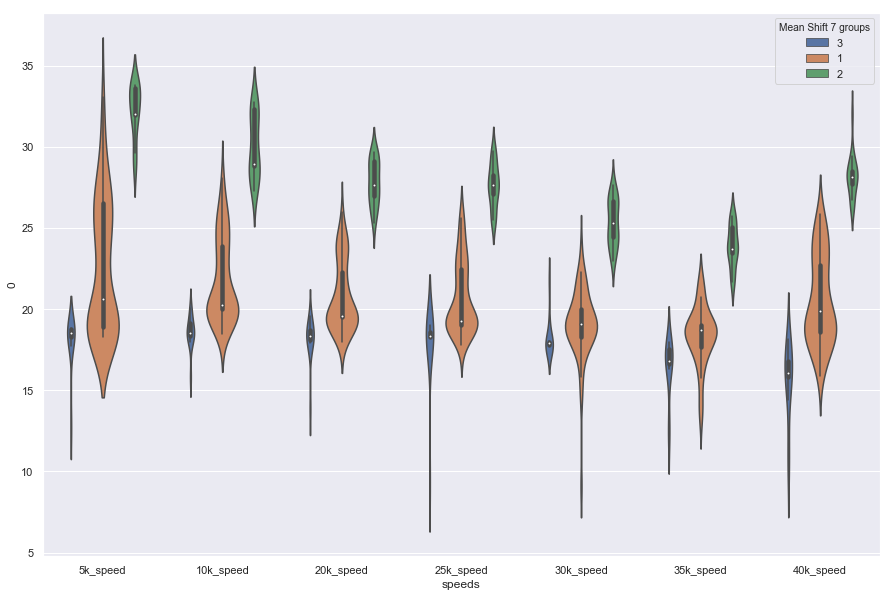

In [122]:
plt.figure(figsize=(15,10));
sns.violinplot(data=show_speeds_with_groups[show_speeds_with_groups["Mean Shift 7 groups"]!=0],x="speeds",y=0,hue="Mean Shift 7 groups",hue_order=(3,1,2),scale="count")

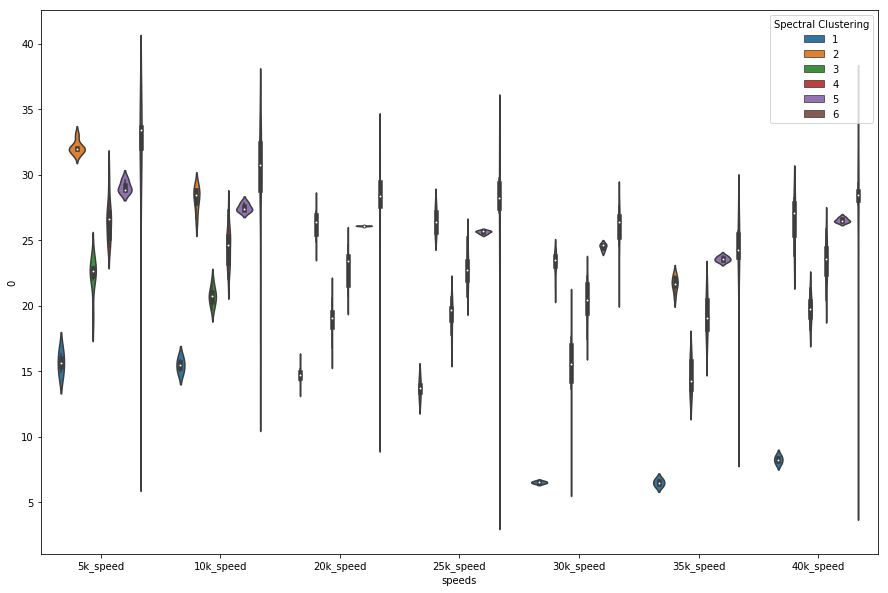

In [99]:
plt.figure(figsize=(15,10));
sns.violinplot(data=show_speeds_with_groups[show_speeds_with_groups["Spectral Clustering"]!=0],x="speeds",y=0,hue="Spectral Clustering")

In [120]:
data_for_cluster["Mean Shift 7 groups"].value_counts()

0    15966
1       56
2       19
3       13
Name: Mean Shift 7 groups, dtype: int64

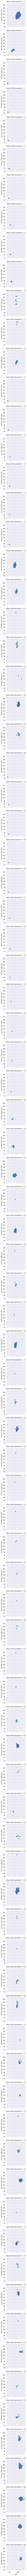

In [110]:
#runners = show_speeds_with_groups[show_speeds_with_groups["Spectral Clustering"]!=0]
#plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Use seaborn for easy faceting
g = sns.FacetGrid(data_for_cluster, row="Mean Shift bandwith 2")
g = (g.map(plt.scatter, "half", "second_half_time"))

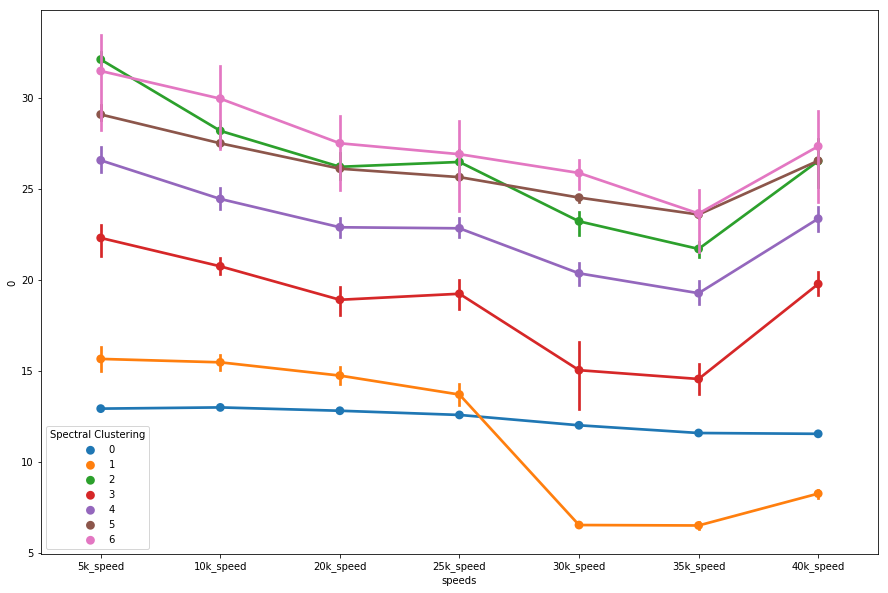

In [96]:
plt.figure(figsize=(15,10));
sns.pointplot(data=show_speeds_with_groups,x="speeds",y=0,hue="Spectral Clustering")

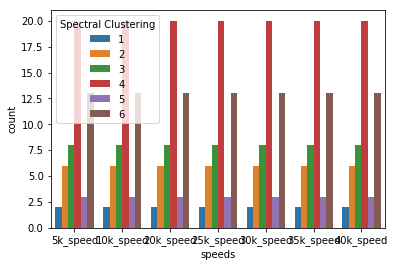

In [100]:
sns.countplot(data=show_speeds_with_groups[show_speeds_with_groups["Spectral Clustering"]!=0],x="speeds",hue="Spectral Clustering")